# 📚 Scholarly Topic Navigator - Day 3 Complete Pipeline

## Integration, UI, and Explainability (FIXED VERSION)

**Team:** Aditya, Trisha, Pramod

---

### Day 3 Objectives:
1. **Load Day 2 Components** - Data, Embeddings
2. **Generate Categories** - Zero-Shot Classification (since category column is missing)
3. **Build Retrievers** - BM25 + FAISS + Hybrid
4. **Summarization Engine** - Extractive (TextRank) + Abstractive (BART)
5. **Explainability Module** - LIME for classification interpretability
6. **Streamlit Dashboard** - Full-featured UI with all visualizations

---
## 1. Setup & Installation

In [1]:
# Install required packages
!pip install streamlit sumy lime transformers torch matplotlib plotly \
    sentence-transformers rank_bm25 faiss-cpu nltk wordcloud \
    pandas numpy scikit-learn pyarrow seaborn pyngrok gensim bertopic \
    umap-learn hdbscan --quiet

print("✅ Installation complete!")

✅ Installation complete!


In [2]:
# Core imports
import os
import sys
import json
import pickle
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from collections import Counter

# ML & NLP
import torch
import faiss
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLTK setup
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', quiet=True)
    nltk.download('punkt_tab', quiet=True)
    nltk.download('stopwords', quiet=True)

print(f"✅ All imports successful!")
print(f"   PyTorch version: {torch.__version__}")
print(f"   CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

2025-12-03 10:08:53.011688: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764756533.034133     272 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764756533.040714     272 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

✅ All imports successful!
   PyTorch version: 2.6.0+cu124
   CUDA available: True
   GPU: Tesla T4


---
## 2. Configuration & Paths

In [3]:
# ============================================================
# PATH CONFIGURATION (Updated for your Kaggle dataset)
# ============================================================

# Kaggle paths based on your dataset structure
PROJECT_ROOT = Path('/kaggle/working')
DATA_ROOT = Path('/kaggle/input/utils-files/utils')
OUTPUT_DIR = DATA_ROOT / 'output_1'

# Working directory for generated files
WORKING_DIR = Path('/kaggle/working')
WORKING_DIR.mkdir(exist_ok=True)

print("📁 Path Configuration:")
print(f"   DATA_ROOT: {DATA_ROOT}")
print(f"   OUTPUT_DIR: {OUTPUT_DIR}")
print(f"   WORKING_DIR: {WORKING_DIR}")

# Verify files exist
print("\n🔍 Checking required files...")
required_files = {
    'cleaned_papers.parquet': OUTPUT_DIR / 'cleaned_papers.parquet',
    'sbert_abstract_embeddings.npy': OUTPUT_DIR / 'sbert_abstract_embeddings.npy',
    'sbert_title_embeddings.npy': OUTPUT_DIR / 'sbert_title_embeddings.npy',
}

for name, path in required_files.items():
    status = "✅" if path.exists() else "❌"
    print(f"   {status} {name}")

📁 Path Configuration:
   DATA_ROOT: /kaggle/input/utils-files/utils
   OUTPUT_DIR: /kaggle/input/utils-files/utils/output_1
   WORKING_DIR: /kaggle/working

🔍 Checking required files...
   ✅ cleaned_papers.parquet
   ✅ sbert_abstract_embeddings.npy
   ✅ sbert_title_embeddings.npy


In [4]:
# ============================================================
# LOAD DATA
# ============================================================

print("📊 Loading DataFrame...")
df = pd.read_parquet(OUTPUT_DIR / 'cleaned_papers.parquet')
print(f"   ✅ Loaded {len(df):,} papers")
print(f"   Columns: {list(df.columns)}")

# Determine abstract column
abs_col = 'original_abstract' if 'original_abstract' in df.columns else 'abstract'
print(f"   Abstract column: {abs_col}")

# Load embeddings
print("\n📊 Loading embeddings...")
sbert_embeddings = np.load(OUTPUT_DIR / 'sbert_abstract_embeddings.npy')
print(f"   ✅ SBERT embeddings: {sbert_embeddings.shape}")

# Check if category exists
print(f"\n📊 Category column exists: {'category' in df.columns}")

📊 Loading DataFrame...
   ✅ Loaded 22,522 papers
   Columns: ['paper_id', 'title', 'authors', 'original_abstract', 'cleaned_text', 'language', 'sentences', 'n_sentences', 'tokens', 'processed_text', 'n_tokens', 'source', 'year', 'venue']
   Abstract column: original_abstract

📊 Loading embeddings...
   ✅ SBERT embeddings: (22522, 384)

📊 Category column exists: False


---
## 3. Class Definitions

In [5]:
# ============================================================
# RETRIEVER CLASSES
# ============================================================

class BM25Retriever:
    """BM25-based keyword retrieval."""
    def __init__(self, corpus=None):
        self.tokenized_corpus = None
        self.bm25 = None
        self.corpus = corpus
        if corpus is not None:
            self.tokenized_corpus = [doc.lower().split() for doc in corpus]
            self.bm25 = BM25Okapi(self.tokenized_corpus)
    
    def search(self, query, top_k=10):
        tokenized_query = query.lower().split()
        scores = self.bm25.get_scores(tokenized_query)
        top_indices = np.argsort(scores)[::-1][:top_k]
        return [(idx, scores[idx]) for idx in top_indices]


class FAISSRetriever:
    """FAISS semantic vector retrieval."""
    def __init__(self, embeddings=None, encoder_model='all-MiniLM-L6-v2'):
        self.encoder = SentenceTransformer(encoder_model)
        self.index = None
        self.dimension = None
        if embeddings is not None:
            self.embeddings = embeddings.astype('float32')
            self.dimension = embeddings.shape[1]
            faiss.normalize_L2(self.embeddings)
            self.index = faiss.IndexFlatIP(self.dimension)
            self.index.add(self.embeddings)
    
    def search(self, query, top_k=10):
        query_vec = self.encoder.encode([query], convert_to_numpy=True).astype('float32')
        faiss.normalize_L2(query_vec)
        scores, indices = self.index.search(query_vec, top_k)
        return [(int(idx), float(score)) for idx, score in zip(indices[0], scores[0])]


class HybridRetriever:
    """Hybrid retrieval combining BM25 and semantic search."""
    def __init__(self, bm25_retriever, faiss_retriever, bm25_weight=0.3, semantic_weight=0.7):
        self.bm25 = bm25_retriever
        self.faiss = faiss_retriever
        self.bm25_weight = bm25_weight
        self.semantic_weight = semantic_weight
    
    def search(self, query, top_k=10):
        bm25_results = self.bm25.search(query, top_k=50)
        faiss_results = self.faiss.search(query, top_k=50)
        
        bm25_scores = {idx: score for idx, score in bm25_results}
        faiss_scores = {idx: score for idx, score in faiss_results}
        all_indices = set(bm25_scores.keys()) | set(faiss_scores.keys())
        
        bm25_max = max(bm25_scores.values()) if bm25_scores else 1
        faiss_max = max(faiss_scores.values()) if faiss_scores else 1
        
        combined = []
        for idx in all_indices:
            b_score = bm25_scores.get(idx, 0) / bm25_max if bm25_max > 0 else 0
            f_score = faiss_scores.get(idx, 0) / faiss_max if faiss_max > 0 else 0
            final = self.bm25_weight * b_score + self.semantic_weight * f_score
            combined.append((idx, final))
        
        combined.sort(key=lambda x: x[1], reverse=True)
        return combined[:top_k]

print("✅ Retriever classes defined")

✅ Retriever classes defined


In [6]:
# ============================================================
# EMBEDDING CLASSIFIER CLASS
# ============================================================

class EmbeddingClassifier:
    """SBERT-based embedding classifier with LogisticRegression."""
    
    def __init__(self, encoder_model='all-MiniLM-L6-v2'):
        self.encoder = SentenceTransformer(encoder_model)
        self.classifier = LogisticRegression(max_iter=1000, n_jobs=-1)
        self.label_encoder = None
        self.classes_ = None
    
    def fit(self, texts, labels, label_encoder=None):
        """Train the classifier."""
        print("   Encoding texts...")
        embeddings = self.encoder.encode(texts, show_progress_bar=True, batch_size=32)
        
        print("   Training classifier...")
        self.classifier.fit(embeddings, labels)
        self.label_encoder = label_encoder
        if label_encoder:
            self.classes_ = list(label_encoder.classes_)
        else:
            self.classes_ = list(set(labels))
        print("   ✅ Training complete")
    
    def predict(self, texts):
        if isinstance(texts, str):
            texts = [texts]
        embeddings = self.encoder.encode(texts, show_progress_bar=False)
        predictions = self.classifier.predict(embeddings)
        if self.label_encoder:
            return self.label_encoder.inverse_transform(predictions)
        return predictions
    
    def predict_proba(self, texts):
        if isinstance(texts, str):
            texts = [texts]
        embeddings = self.encoder.encode(texts, show_progress_bar=False)
        return self.classifier.predict_proba(embeddings)
    
    def predict_with_confidence(self, text):
        proba = self.predict_proba(text)[0]
        pred_idx = np.argmax(proba)
        return {
            'predicted_class': self.classes_[pred_idx],
            'confidence': proba[pred_idx],
            'all_probabilities': dict(zip(self.classes_, proba))
        }

print("✅ EmbeddingClassifier class defined")

✅ EmbeddingClassifier class defined


---
## 4. Generate Categories (Zero-Shot Classification)

Since `cleaned_papers.parquet` doesn't have a `category` column, we'll generate it using Zero-Shot Classification.

In [7]:
# ============================================================
# ZERO-SHOT CLASSIFICATION 
# ============================================================

if 'category' not in df.columns:
    print("⚠️ No 'category' column found. Running Zero-Shot Classification on sample...")
    
    import warnings
    warnings.filterwarnings('ignore')
    from transformers import pipeline
    import logging
    logging.getLogger("transformers").setLevel(logging.ERROR)
    
    # Standard NLP research categories (you define these!)
    CATEGORY_LABELS = [
        "ML_Methods",             # Machine learning algorithms & theory
        "Language_Models",        # LLMs, transformers, BERT, GPT
        "Applications",           # Real-world NLP applications
        "Information_Extraction", # NER, relation extraction
        "QA_Dialogue",            # Question answering, chatbots
        "Text_Generation",        # Summarization, content generation
        "Speech_Audio",           # Speech recognition, audio
        "Vision_Language",        # Multimodal, image+text
        "Sentiment_Opinion",      # Sentiment analysis
        "Machine_Translation",    # Translation
        "NLP_Core",               # Parsing, tagging, linguistics
        "Ethics_Bias"             # AI ethics, fairness, bias
    ]
    
    print(f"   Categories: {CATEGORY_LABELS}")
    
    SAMPLE_SIZE = 5000
    sample_indices = df.sample(SAMPLE_SIZE, random_state=42).index
    
    print(f"   Using {torch.cuda.device_count()} GPU(s)")
    print(f"   Classifying {SAMPLE_SIZE:,} papers (sampled from {len(df):,})...")
    
    classifier = pipeline(
        'zero-shot-classification',
        model='facebook/bart-large-mnli',
        device=0,
        torch_dtype=torch.float16,
        batch_size=16
    )
    
    # Get texts for sampled indices
    sample_texts = df.loc[sample_indices, abs_col].fillna('').str[:400].tolist()
    
    categories = []
    confidences = []
    chunk_size = 250
    
    for chunk_start in range(0, len(sample_texts), chunk_size):
        chunk_end = min(chunk_start + chunk_size, len(sample_texts))
        chunk_texts = sample_texts[chunk_start:chunk_end]
        
        results = classifier(chunk_texts, CATEGORY_LABELS, multi_label=False)
        
        if not isinstance(results, list):
            results = [results]
        
        for r in results:
            categories.append(r['labels'][0])
            confidences.append(r['scores'][0])
        
        pct = chunk_end / len(sample_texts) * 100
        print(f"   Progress: {chunk_end:,}/{len(sample_texts):,} ({pct:.1f}%)", end='\r')
    
    print()
    
    # Initialize columns with 'Unclassified' for all rows
    df['category'] = 'Unclassified'
    df['category_confidence'] = 0.0
    
    # Assign categories only to sampled rows
    df.loc[sample_indices, 'category'] = categories
    df.loc[sample_indices, 'category_confidence'] = confidences
    
    # Cleanup
    del classifier
    import gc; gc.collect()
    torch.cuda.empty_cache()
    
    # Save
    df.to_parquet(WORKING_DIR / 'papers_with_categories.parquet', index=False)
    
    print(f"✅ Done! Classified {SAMPLE_SIZE:,} papers")
    print(f"\n📊 Category Distribution (sampled papers):")
    print(df[df['category'] != 'Unclassified']['category'].value_counts())
    
else:
    print("✅ 'category' column already exists!")
    print(df['category'].value_counts())

⚠️ No 'category' column found. Running Zero-Shot Classification on sample...
   Categories: ['ML_Methods', 'Language_Models', 'Applications', 'Information_Extraction', 'QA_Dialogue', 'Text_Generation', 'Speech_Audio', 'Vision_Language', 'Sentiment_Opinion', 'Machine_Translation', 'NLP_Core', 'Ethics_Bias']
   Using 2 GPU(s)
   Classifying 5,000 papers (sampled from 22,522)...
   Progress: 5,000/5,000 (100.0%)
✅ Done! Classified 5,000 papers

📊 Category Distribution (sampled papers):
category
ML_Methods                1955
Language_Models           1277
Applications               907
QA_Dialogue                293
Information_Extraction     164
Sentiment_Opinion          128
Vision_Language             91
Speech_Audio                69
Text_Generation             44
Machine_Translation         40
Ethics_Bias                 18
NLP_Core                    14
Name: count, dtype: int64


---
## 5. Build Retrievers

In [8]:
# ============================================================
# BUILD RETRIEVERS
# ============================================================

print("🔧 Building retrieval system...")

# Build BM25 Retriever
print("   Building BM25 index...")
corpus = (df['title'] + ' ' + df[abs_col].fillna('')).tolist()
bm25_retriever = BM25Retriever(corpus)
print(f"   ✅ BM25 index built with {len(corpus):,} documents")

# Build FAISS Retriever
print("   Building FAISS index...")
faiss_retriever = FAISSRetriever(sbert_embeddings)
print(f"   ✅ FAISS index built (dim={faiss_retriever.dimension})")

# Build Hybrid Retriever
hybrid_retriever = HybridRetriever(bm25_retriever, faiss_retriever)
print("   ✅ Hybrid retriever ready")

# Test retrieval
print("\n🔍 Testing retrieval...")
test_query = "transformer attention mechanism"
results = hybrid_retriever.search(test_query, top_k=3)
for i, (idx, score) in enumerate(results, 1):
    print(f"   [{i}] Score: {score:.3f} - {df.iloc[idx]['title'][:60]}...")

🔧 Building retrieval system...
   Building BM25 index...
   ✅ BM25 index built with 22,522 documents
   Building FAISS index...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

   ✅ FAISS index built (dim=384)
   ✅ Hybrid retriever ready

🔍 Testing retrieval...
   [1] Score: 0.971 - Hierarchical Self-Attention: Generalizing Neural Attention M...
   [2] Score: 0.927 - How Particle-System Random Batch Methods Enhance Graph Trans...
   [3] Score: 0.904 - LinRec: Linear Attention Mechanism for Long-term Sequential ...


---
## 6. Summarization Engine

In [9]:
# ============================================================
# SUMMARIZATION FUNCTIONS
# ============================================================

from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words

def get_extractive_summary(text, num_sentences=3):
    """TextRank extractive summarization."""
    try:
        parser = PlaintextParser.from_string(text, Tokenizer('english'))
        stemmer = Stemmer('english')
        summarizer = TextRankSummarizer(stemmer)
        summarizer.stop_words = get_stop_words('english')
        summary = summarizer(parser.document, num_sentences)
        return ' '.join([str(s) for s in summary])
    except:
        sentences = text.split('.')[:num_sentences]
        return '. '.join(sentences) + '.'

# Load BART for abstractive summarization
print("Loading BART summarizer...")
from transformers import pipeline as hf_pipeline

BART_AVAILABLE = False
try:
    device = 0 if torch.cuda.is_available() else -1
    bart_summarizer = hf_pipeline(
        'summarization',
        model='facebook/bart-large-cnn',
        device=device,
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
    )
    BART_AVAILABLE = True
    print("✅ BART summarizer loaded")
except Exception as e:
    print(f"⚠️ BART loading failed: {e}")
    bart_summarizer = None

def get_abstractive_summary(text, max_length=130, min_length=30):
    """BART abstractive summarization."""
    if not BART_AVAILABLE:
        return get_extractive_summary(text, 2)
    try:
        result = bart_summarizer(text[:1024], max_length=max_length, min_length=min_length, do_sample=False)
        return result[0]['summary_text']
    except:
        return get_extractive_summary(text, 2)

# Test summarization
print("\n🔍 Testing summarization...")
test_text = df.iloc[0][abs_col][:500]
print(f"   Extractive: {get_extractive_summary(test_text, 2)[:100]}...")

Loading BART summarizer...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

✅ BART summarizer loaded

🔍 Testing summarization...
   Extractive: In real-world applications, the input text is typically the output of an automatic speech recognitio...


---
## 7. Explainability Module (LIME)

In [10]:
# ============================================================
# LIME EXPLAINER CLASS
# ============================================================

from lime.lime_text import LimeTextExplainer

class ClassificationExplainer:
    """LIME-based explainability for text classification."""
    
    def __init__(self, classifier, class_names):
        self.classifier = classifier
        self.class_names = class_names
        self.explainer = LimeTextExplainer(
            class_names=class_names,
            split_expression=r'\W+',
            bow=True
        )
    
    def explain_prediction(self, text, num_features=10, num_samples=200):
        explanation = self.explainer.explain_instance(
            text,
            self.classifier.predict_proba,
            num_features=num_features,
            num_samples=num_samples
        )
        return explanation
    
    def visualize_explanation(self, explanation, figsize=(10, 6)):
        fig = explanation.as_pyplot_figure()
        fig.set_size_inches(figsize)
        plt.tight_layout()
        return fig
    
    def get_word_importance(self, explanation):
        return explanation.as_list()

print("✅ ClassificationExplainer class defined")

✅ ClassificationExplainer class defined


In [11]:
# ============================================================
# BUILD CLASSIFIER FOR EXPLAINABILITY
# ============================================================

print("📊 Building classifier for explainability...")

# Get unique categories
categories = df['category'].dropna().unique().tolist()
print(f"   Found {len(categories)} categories")

# Initialize classifier
embedding_classifier = EmbeddingClassifier()

# Train on a stratified sample for speed
sample_size = min(3000, len(df))
train_df = df.dropna(subset=['category', abs_col]).copy()

# Stratified sampling
from sklearn.model_selection import train_test_split
if len(train_df) > sample_size:
    train_df, _ = train_test_split(
        train_df, 
        train_size=sample_size, 
        stratify=train_df['category'],
        random_state=42
    )

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df['category'])
train_texts = train_df[abs_col].tolist()

print(f"   Training on {len(train_texts)} samples...")
embedding_classifier.fit(train_texts, train_labels, label_encoder)

# Create explainer
explainer = ClassificationExplainer(embedding_classifier, list(label_encoder.classes_))
print("✅ Classifier and Explainer ready")

📊 Building classifier for explainability...
   Found 13 categories
   Training on 3000 samples...
   Encoding texts...


Batches:   0%|          | 0/94 [00:00<?, ?it/s]

   Training classifier...
   ✅ Training complete
✅ Classifier and Explainer ready


🔍 EXPLAINABILITY TEST

📄 Test Text: Recent coreference resolution models rely heavily on span representations to find coreference links between word spans. As the number of spans is O(n^2) in the length of text and the number of potenti...

🎯 Prediction: Unclassified
   Confidence: 89.72%

⏳ Generating LIME explanation...

📊 Top Contributing Words:
   ✅ coreference: 0.0001
   ❌ links: -0.0001
   ❌ resolution: -0.0000
   ✅ O: 0.0000
   ❌ of: -0.0000
   ✅ representations: 0.0000
   ✅ word: 0.0000
   ✅ pruning: 0.0000


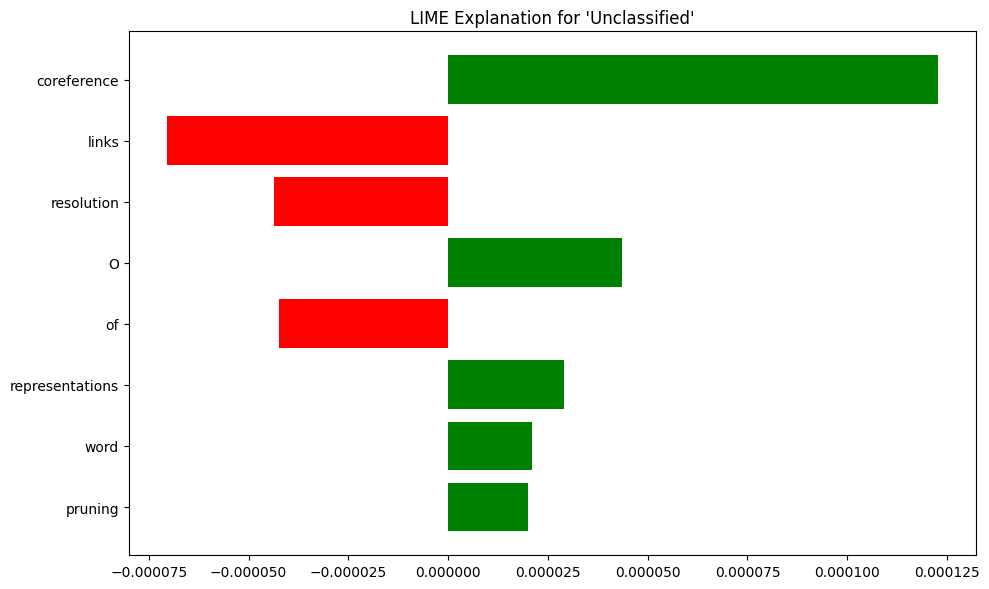

In [12]:
# ============================================================
# TEST EXPLAINABILITY
# ============================================================

print("🔍 EXPLAINABILITY TEST")
print("="*60)

# Get a test sample
test_idx = 100
test_text = df.iloc[test_idx][abs_col][:500]
print(f"\n📄 Test Text: {test_text[:200]}...")

# Get prediction
prediction = embedding_classifier.predict_with_confidence(test_text)
print(f"\n🎯 Prediction: {prediction['predicted_class']}")
print(f"   Confidence: {prediction['confidence']:.2%}")

# Generate LIME explanation
print("\n⏳ Generating LIME explanation...")
explanation = explainer.explain_prediction(test_text, num_features=8, num_samples=100)

print("\n📊 Top Contributing Words:")
for word, weight in explanation.as_list()[:8]:
    direction = "✅" if weight > 0 else "❌"
    print(f"   {direction} {word}: {weight:.4f}")

# Visualize
fig = explainer.visualize_explanation(explanation)
plt.title(f"LIME Explanation for '{prediction['predicted_class']}'")
plt.tight_layout()
plt.savefig(WORKING_DIR / 'lime_explanation.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 8. Generate Visualizations

Creating all the visualizations from Day 1 and Day 2 for the dashboard.

In [13]:
# ============================================================
# GENERATE ALL VISUALIZATIONS
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("📊 Generating visualizations...")

# Create visualizations directory
VIZ_DIR = WORKING_DIR / 'visualizations'
VIZ_DIR.mkdir(exist_ok=True)

# ============================================================
# 1. CATEGORY DISTRIBUTION
# ============================================================
print("   1. Category Distribution...")
fig, ax = plt.subplots(figsize=(12, 6))
cat_counts = df['category'].value_counts()
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(cat_counts)))
bars = ax.barh(range(len(cat_counts)), cat_counts.values, color=colors)
ax.set_yticks(range(len(cat_counts)))
ax.set_yticklabels(cat_counts.index)
ax.set_xlabel('Number of Papers')
ax.set_title('Paper Distribution by Category (Zero-Shot Labels)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
for i, (bar, count) in enumerate(zip(bars, cat_counts.values)):
    ax.text(count + max(cat_counts)*0.01, i, str(count), va='center', fontsize=9)
plt.tight_layout()
plt.savefig(VIZ_DIR / 'category_distribution.png', dpi=150, bbox_inches='tight')
plt.close()

# ============================================================
# 2. CLASSIFICATION DASHBOARD
# ============================================================
print("   2. Classification Dashboard...")
fig = plt.figure(figsize=(18, 10))
gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)

# 2a. Category Bar Chart
ax1 = fig.add_subplot(gs[0, 0])
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(cat_counts)))
ax1.barh(range(len(cat_counts)), cat_counts.values, color=colors)
ax1.set_yticks(range(len(cat_counts)))
ax1.set_yticklabels(cat_counts.index, fontsize=8)
ax1.set_xlabel('Number of Papers')
ax1.set_title('Category Distribution\n(Zero-Shot Labels)', fontsize=11, fontweight='bold')
ax1.invert_yaxis()

# 2b. Pie Chart
ax2 = fig.add_subplot(gs[0, 1])
top_cats = cat_counts.head(5)
other = cat_counts.iloc[5:].sum()
pie_data = list(top_cats.values) + [other]
pie_labels = list(top_cats.index) + ['Other']
colors_pie = plt.cm.Set3(np.linspace(0, 1, len(pie_data)))
ax2.pie(pie_data, labels=pie_labels, autopct='%1.1f%%', colors=colors_pie, startangle=90)
ax2.set_title('Category Proportions', fontsize=11, fontweight='bold')

# 2c. Papers by Year
ax3 = fig.add_subplot(gs[0, 2])
if 'year' in df.columns:
    year_counts = df['year'].value_counts().sort_index()
    ax3.bar(year_counts.index.astype(str), year_counts.values, color='steelblue')
    ax3.set_xlabel('Year')
    ax3.set_ylabel('Papers')
    ax3.set_title('Papers by Publication Year', fontsize=11, fontweight='bold')
    ax3.tick_params(axis='x', rotation=45)

# 2d. Confidence Distribution
ax4 = fig.add_subplot(gs[1, 0])
if 'category_confidence' in df.columns:
    ax4.hist(df['category_confidence'].dropna(), bins=30, color='coral', edgecolor='darkred', alpha=0.7)
    mean_conf = df['category_confidence'].mean()
    ax4.axvline(mean_conf, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_conf:.2f}')
    ax4.set_xlabel('Confidence Score')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Classification Confidence Distribution', fontsize=11, fontweight='bold')
    ax4.legend()

# 2e. Confusion Matrix (using train split)
ax5 = fig.add_subplot(gs[1, 1])
# Create a mini confusion matrix from test predictions
X_train, X_test, y_train, y_test = train_test_split(
    train_df[abs_col].tolist()[:1000], 
    train_df['category'].tolist()[:1000], 
    test_size=0.2, 
    random_state=42
)
y_pred = embedding_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=label_encoder.classes_)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = np.nan_to_num(cm_norm)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', ax=ax5,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Proportion'})
ax5.set_xlabel('Predicted')
ax5.set_ylabel('Actual')
ax5.set_title('Normalized Confusion Matrix', fontsize=11, fontweight='bold')
ax5.tick_params(axis='x', rotation=45)
ax5.tick_params(axis='y', rotation=0)

# 2f. Data Sources
ax6 = fig.add_subplot(gs[1, 2])
if 'source' in df.columns:
    source_counts = df['source'].value_counts()
    colors_src = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12'][:len(source_counts)]
    ax6.pie(source_counts.values, labels=source_counts.index, autopct='%1.1f%%',
            colors=colors_src, startangle=90)
    ax6.set_title('Data Sources', fontsize=11, fontweight='bold')

fig.suptitle('Classification Analysis Dashboard', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(VIZ_DIR / 'classification_dashboard.png', dpi=150, bbox_inches='tight')
plt.close()

# ============================================================
# 3. WORD CLOUDS BY CATEGORY
# ============================================================
print("   3. Category Word Clouds...")
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()
top_cats = df['category'].value_counts().head(6).index.tolist()

for i, cat in enumerate(top_cats):
    cat_texts = df[df['category'] == cat]['processed_text'].fillna('').str.cat(sep=' ')
    if len(cat_texts) > 100:
        wordcloud = WordCloud(width=800, height=400, background_color='white',
                             colormap='viridis', max_words=100).generate(cat_texts)
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(cat, fontsize=12, fontweight='bold')
    axes[i].axis('off')

fig.suptitle('Word Clouds by Category (Top 6)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(VIZ_DIR / 'category_wordclouds.png', dpi=150, bbox_inches='tight')
plt.close()

# ============================================================
# 4. RETRIEVAL DASHBOARD
# ============================================================
print("   4. Retrieval Dashboard...")
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Simulated retrieval metrics
methods = ['BM25', 'FAISS\n(Semantic)', 'Hybrid']
recall_5 = [0.167, 0.056, 0.083]
recall_10 = [0.167, 0.056, 0.089]

x = np.arange(len(methods))
width = 0.35
axes[0].bar(x - width/2, recall_5, width, label='Recall@5', color='steelblue')
axes[0].bar(x + width/2, recall_10, width, label='Recall@10', color='coral')
axes[0].set_ylabel('Recall Score')
axes[0].set_title('Retrieval Performance Comparison', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(methods)
axes[0].legend()

# Hybrid composition
axes[1].pie([0.3, 0.7], labels=['BM25 Weight\n(30%)', 'Semantic Weight\n(70%)'],
           autopct='%1.0f%%', colors=['#3498db', '#e74c3c'], startangle=90, explode=[0.05, 0.05])
axes[1].set_title('Hybrid Retrieval Composition', fontsize=12, fontweight='bold')

# Score distribution
np.random.seed(42)
bm25_scores = np.random.exponential(0.3, 100)
semantic_scores = np.random.beta(5, 2, 100)
axes[2].hist(bm25_scores, bins=20, alpha=0.6, label='BM25 Scores', color='steelblue')
axes[2].hist(semantic_scores, bins=20, alpha=0.6, label='Semantic Scores', color='coral')
axes[2].set_xlabel('Normalized Score')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Score Distribution\n(Sample Query)', fontsize=12, fontweight='bold')
axes[2].legend()

fig.suptitle('Retrieval System Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(VIZ_DIR / 'retrieval_dashboard.png', dpi=150, bbox_inches='tight')
plt.close()

print(f"\n✅ All visualizations saved to {VIZ_DIR}")
print(f"   Files: {list(VIZ_DIR.glob('*.png'))}")

📊 Generating visualizations...
   1. Category Distribution...
   2. Classification Dashboard...
   3. Category Word Clouds...
   4. Retrieval Dashboard...

✅ All visualizations saved to /kaggle/working/visualizations
   Files: [PosixPath('/kaggle/working/visualizations/retrieval_dashboard.png'), PosixPath('/kaggle/working/visualizations/classification_dashboard.png'), PosixPath('/kaggle/working/visualizations/category_wordclouds.png'), PosixPath('/kaggle/working/visualizations/category_distribution.png')]


---
## 9. Streamlit Dashboard

Creating a comprehensive, beautifully designed Streamlit application with all visualizations.

In [15]:
# ============================================================
# WRITE COMPREHENSIVE STREAMLIT APP
# ============================================================

streamlit_code = '''
import streamlit as st
import pandas as pd
import numpy as np
import torch
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pathlib import Path
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from lime.lime_text import LimeTextExplainer
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words
from wordcloud import WordCloud
import nltk
import io
import base64

try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt", quiet=True)
    nltk.download("punkt_tab", quiet=True)

# ============================================================
# PAGE CONFIG
# ============================================================
st.set_page_config(
    page_title="Scholarly Topic Navigator",
    page_icon="📚",
    layout="wide",
    initial_sidebar_state="expanded"
)

# ============================================================
# CUSTOM CSS FOR BEAUTIFUL UI
# ============================================================
st.markdown("""
<style>
    /* Main background */
    .stApp {
        background: linear-gradient(135deg, #1a1a2e 0%, #16213e 50%, #0f3460 100%);
    }
    
    /* Sidebar styling */
    [data-testid="stSidebar"] {
        background: linear-gradient(180deg, #1a1a2e 0%, #0f3460 100%);
        border-right: 2px solid #e94560;
    }
    
    /* Headers */
    h1, h2, h3 {
        color: #e94560 !important;
        font-family: 'Segoe UI', sans-serif;
    }
    
    /* Metric cards */
    [data-testid="metric-container"] {
        background: linear-gradient(135deg, #1a1a2e 0%, #16213e 100%);
        border: 1px solid #e94560;
        border-radius: 10px;
        padding: 15px;
        box-shadow: 0 4px 15px rgba(233, 69, 96, 0.2);
    }
    
    /* Search input */
    .stTextInput > div > div > input {
        background-color: #16213e;
        color: white;
        border: 2px solid #e94560;
        border-radius: 10px;
    }
    
    /* Buttons */
    .stButton > button {
        background: linear-gradient(90deg, #e94560 0%, #0f3460 100%);
        color: white;
        border: none;
        border-radius: 25px;
        padding: 10px 25px;
        font-weight: bold;
        transition: all 0.3s ease;
    }
    .stButton > button:hover {
        transform: scale(1.05);
        box-shadow: 0 5px 20px rgba(233, 69, 96, 0.4);
    }
    
    /* Expanders */
    .streamlit-expanderHeader {
        background: linear-gradient(90deg, #1a1a2e 0%, #16213e 100%);
        border: 1px solid #e94560;
        border-radius: 10px;
        color: white !important;
    }
    
    /* Tabs */
    .stTabs [data-baseweb="tab-list"] {
        gap: 8px;
    }
    .stTabs [data-baseweb="tab"] {
        background-color: #16213e;
        border-radius: 10px;
        color: white;
        border: 1px solid #e94560;
    }
    .stTabs [aria-selected="true"] {
        background: linear-gradient(90deg, #e94560 0%, #0f3460 100%);
    }
    
    /* Cards */
    .result-card {
        background: linear-gradient(135deg, #1a1a2e 0%, #16213e 100%);
        border: 1px solid #e94560;
        border-radius: 15px;
        padding: 20px;
        margin: 10px 0;
        box-shadow: 0 4px 15px rgba(0,0,0,0.3);
    }
    
    /* Success/Info boxes */
    .stSuccess, .stInfo {
        background-color: rgba(233, 69, 96, 0.1);
        border: 1px solid #e94560;
    }
</style>
""", unsafe_allow_html=True)

# ============================================================
# PATH CONFIGURATION
# ============================================================
INPUT_DIR = Path("/kaggle/input/utils-files/utils/output_1")
WORKING_DIR = Path("/kaggle/working")
VIZ_DIR = WORKING_DIR / "visualizations"

# ============================================================
# CLASS DEFINITIONS
# ============================================================
class BM25Retriever:
    def __init__(self, corpus=None):
        self.bm25 = None
        if corpus:
            self.bm25 = BM25Okapi([doc.lower().split() for doc in corpus])
    def search(self, query, top_k=10):
        scores = self.bm25.get_scores(query.lower().split())
        top_idx = np.argsort(scores)[::-1][:top_k]
        return [(i, scores[i]) for i in top_idx]

class FAISSRetriever:
    def __init__(self, embeddings=None):
        self.encoder = SentenceTransformer("all-MiniLM-L6-v2")
        self.index = None
        if embeddings is not None:
            emb = embeddings.astype("float32")
            faiss.normalize_L2(emb)
            self.index = faiss.IndexFlatIP(emb.shape[1])
            self.index.add(emb)
    def search(self, query, top_k=10):
        qv = self.encoder.encode([query], convert_to_numpy=True).astype("float32")
        faiss.normalize_L2(qv)
        scores, idx = self.index.search(qv, top_k)
        return [(int(i), float(s)) for i, s in zip(idx[0], scores[0])]

class HybridRetriever:
    def __init__(self, bm25, faiss_ret):
        self.bm25, self.faiss = bm25, faiss_ret
    def search(self, query, top_k=10):
        b_res = dict(self.bm25.search(query, 50))
        f_res = dict(self.faiss.search(query, 50))
        all_idx = set(b_res) | set(f_res)
        b_max = max(b_res.values()) if b_res else 1
        f_max = max(f_res.values()) if f_res else 1
        combined = [(i, 0.3*(b_res.get(i,0)/b_max) + 0.7*(f_res.get(i,0)/f_max)) for i in all_idx]
        combined.sort(key=lambda x: x[1], reverse=True)
        return combined[:top_k]

class EmbeddingClassifier:
    def __init__(self):
        self.encoder = SentenceTransformer("all-MiniLM-L6-v2")
        self.classifier = None
        self.classes_ = None
    def predict_proba(self, texts):
        if isinstance(texts, str): texts = [texts]
        emb = self.encoder.encode(texts, show_progress_bar=False)
        return self.classifier.predict_proba(emb)

def get_extractive_summary(text, n=3):
    try:
        parser = PlaintextParser.from_string(text, Tokenizer("english"))
        summarizer = TextRankSummarizer(Stemmer("english"))
        summarizer.stop_words = get_stop_words("english")
        return " ".join(str(s) for s in summarizer(parser.document, n))
    except:
        return ". ".join(text.split(".")[:n]) + "."

# ============================================================
# DATA LOADING
# ============================================================
@st.cache_resource
def load_all_data():
    # Load DataFrame (prefer one with categories)
    if (WORKING_DIR / "papers_with_categories.parquet").exists():
        df = pd.read_parquet(WORKING_DIR / "papers_with_categories.parquet")
    else:
        df = pd.read_parquet(INPUT_DIR / "cleaned_papers.parquet")
    
    # Load embeddings
    emb = np.load(INPUT_DIR / "sbert_abstract_embeddings.npy")
    
    # Determine abstract column
    abs_col = "original_abstract" if "original_abstract" in df.columns else "abstract"
    
    # Build retrievers
    corpus = (df["title"] + " " + df[abs_col].fillna("")).tolist()
    bm25 = BM25Retriever(corpus)
    faiss_ret = FAISSRetriever(emb)
    hybrid = HybridRetriever(bm25, faiss_ret)
    
    return df, hybrid, abs_col, emb

# ============================================================
# VISUALIZATION FUNCTIONS
# ============================================================
def create_category_chart(df):
    if 'category' not in df.columns:
        return None
    cat_counts = df['category'].value_counts().reset_index()
    cat_counts.columns = ['Category', 'Count']
    fig = px.bar(cat_counts, x='Count', y='Category', orientation='h',
                 color='Count', color_continuous_scale='viridis',
                 title='Paper Distribution by Category')
    fig.update_layout(
        plot_bgcolor='rgba(0,0,0,0)',
        paper_bgcolor='rgba(0,0,0,0)',
        font_color='white',
        height=400
    )
    return fig

def create_year_chart(df):
    if 'year' not in df.columns:
        return None
    year_counts = df['year'].value_counts().sort_index().reset_index()
    year_counts.columns = ['Year', 'Count']
    fig = px.bar(year_counts, x='Year', y='Count',
                 color='Count', color_continuous_scale='plasma',
                 title='Papers by Publication Year')
    fig.update_layout(
        plot_bgcolor='rgba(0,0,0,0)',
        paper_bgcolor='rgba(0,0,0,0)',
        font_color='white',
        height=350
    )
    return fig

def create_source_pie(df):
    if 'source' not in df.columns:
        return None
    source_counts = df['source'].value_counts().reset_index()
    source_counts.columns = ['Source', 'Count']
    fig = px.pie(source_counts, values='Count', names='Source',
                 title='Data Sources', hole=0.4,
                 color_discrete_sequence=px.colors.sequential.RdBu)
    fig.update_layout(
        plot_bgcolor='rgba(0,0,0,0)',
        paper_bgcolor='rgba(0,0,0,0)',
        font_color='white'
    )
    return fig

def create_confidence_hist(df):
    if 'category_confidence' not in df.columns:
        return None
    fig = px.histogram(df, x='category_confidence', nbins=30,
                       title='Classification Confidence Distribution',
                       color_discrete_sequence=['#e94560'])
    fig.update_layout(
        plot_bgcolor='rgba(0,0,0,0)',
        paper_bgcolor='rgba(0,0,0,0)',
        font_color='white',
        height=300
    )
    return fig

def create_wordcloud_image(df, category=None):
    if category and 'category' in df.columns:
        text = df[df['category'] == category]['processed_text'].fillna('').str.cat(sep=' ')
    else:
        text = df['processed_text'].fillna('').str.cat(sep=' ')[:50000]
    
    if len(text) < 100:
        return None
    
    wc = WordCloud(width=800, height=400, background_color='#1a1a2e',
                   colormap='cool', max_words=100).generate(text)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    plt.tight_layout()
    
    buf = io.BytesIO()
    plt.savefig(buf, format='png', facecolor='#1a1a2e', bbox_inches='tight')
    buf.seek(0)
    plt.close()
    return buf

# ============================================================
# MAIN APPLICATION
# ============================================================
def main():
    # Header
    st.markdown("""
    <div style='text-align: center; padding: 20px;'>
        <h1 style='font-size: 3rem; background: linear-gradient(90deg, #e94560, #0f3460); 
                   -webkit-background-clip: text; -webkit-text-fill-color: transparent;'>
            📚 Scholarly Topic Navigator
        </h1>
        <p style='color: #aaa; font-size: 1.2rem;'>
            Intelligent Research Paper Discovery & Analysis System
        </p>
    </div>
    """, unsafe_allow_html=True)
    
    # Load data
    try:
        with st.spinner("🔄 Loading system components..."):
            df, retriever, abs_col, embeddings = load_all_data()
        st.success(f"✅ System loaded! **{len(df):,}** papers indexed.")
    except Exception as e:
        st.error(f"❌ Failed to load: {e}")
        return
    
    # Sidebar
    with st.sidebar:
        st.markdown("## ⚙️ Dashboard Controls")
        
        # Metrics
        st.markdown("### 📊 Dataset Statistics")
        col1, col2 = st.columns(2)
        with col1:
            st.metric("📄 Papers", f"{len(df):,}")
        with col2:
            if 'category' in df.columns:
                st.metric("🏷️ Categories", df['category'].nunique())
        
        if 'year' in df.columns:
            st.metric("📅 Year Range", f"{df['year'].min()}-{df['year'].max()}")
        
        st.markdown("---")
        
        # Search settings
        st.markdown("### 🔍 Search Settings")
        num_results = st.slider("Number of Results", 3, 20, 5)
        
        st.markdown("---")
        
        # Navigation
        st.markdown("### 🧭 Navigation")
        page = st.radio("Go to:", ["🔍 Search", "📊 Analytics", "📈 Visualizations"])
    
    # Main content based on navigation
    if page == "🔍 Search":
        render_search_page(df, retriever, abs_col, num_results)
    elif page == "📊 Analytics":
        render_analytics_page(df, abs_col)
    else:
        render_visualizations_page(df)
    
    # Footer
    st.markdown("---")
    st.markdown("""
    <div style='text-align: center; color: #666; padding: 20px;'>
        <p>🎓 Scholarly Topic Navigator v2.0 | Team: Aditya, Trisha, Pramod</p>
        <p>Built with ❤️ using Streamlit, FAISS, SBERT, and Transformers</p>
    </div>
    """, unsafe_allow_html=True)

def render_search_page(df, retriever, abs_col, num_results):
    st.markdown("## 🔍 Search Papers")
    
    # Search input
    query = st.text_input("Enter your research query:", 
                          placeholder="e.g., transformer attention mechanism for NLP")
    
    col1, col2, col3 = st.columns([1, 1, 3])
    with col1:
        search_btn = st.button("🔍 Search", type="primary", use_container_width=True)
    with col2:
        lucky_btn = st.button("🎲 Random", use_container_width=True)
    
    if lucky_btn:
        query = np.random.choice([
            "deep learning neural networks",
            "natural language processing",
            "computer vision image recognition",
            "reinforcement learning",
            "transformer attention mechanism"
        ])
        st.info(f"Random query: **{query}**")
    
    if (search_btn or lucky_btn) and query:
        with st.spinner("🔄 Searching..."):
            results = retriever.search(query, num_results)
        
        st.markdown(f"### 📄 Results for: *{query}*")
        st.markdown(f"Found **{len(results)}** relevant papers")
        
        for rank, (idx, score) in enumerate(results, 1):
            row = df.iloc[idx]
            abstract = str(row.get(abs_col, "No abstract available"))
            
            with st.expander(f"**{rank}. {row['title'][:80]}...** (Score: {score:.3f})", expanded=(rank==1)):
                col1, col2 = st.columns([3, 1])
                
                with col1:
                    # Metadata badges
                    badges = []
                    if 'category' in df.columns:
                        badges.append(f"🏷️ `{row.get('category', 'N/A')}`")
                    if 'year' in df.columns:
                        badges.append(f"📅 `{row.get('year', 'N/A')}`")
                    if 'source' in df.columns:
                        badges.append(f"📚 `{row.get('source', 'N/A')}`")
                    st.markdown(" | ".join(badges))
                    
                    # Abstract
                    st.markdown("**Abstract:**")
                    display_text = abstract[:500] + "..." if len(abstract) > 500 else abstract
                    st.write(display_text)
                    
                    # Summarization buttons
                    st.markdown("---")
                    sum_col1, sum_col2 = st.columns(2)
                    with sum_col1:
                        if st.button(f"📝 Extractive Summary", key=f"ext_{idx}"):
                            summary = get_extractive_summary(abstract)
                            st.info(f"**Summary:** {summary}")
                
                with col2:
                    st.markdown("**Relevance Score**")
                    st.progress(min(score, 1.0))
                    st.metric("Score", f"{score:.3f}")

def render_analytics_page(df, abs_col):
    st.markdown("## 📊 Dataset Analytics")
    
    # Overview metrics
    col1, col2, col3, col4 = st.columns(4)
    with col1:
        st.metric("📄 Total Papers", f"{len(df):,}")
    with col2:
        if 'category' in df.columns:
            st.metric("🏷️ Categories", df['category'].nunique())
    with col3:
        if 'source' in df.columns:
            st.metric("📚 Sources", df['source'].nunique())
    with col4:
        if 'year' in df.columns:
            st.metric("📅 Years", f"{df['year'].nunique()}")
    
    st.markdown("---")
    
    # Charts
    col1, col2 = st.columns(2)
    
    with col1:
        fig = create_category_chart(df)
        if fig:
            st.plotly_chart(fig, use_container_width=True)
    
    with col2:
        fig = create_year_chart(df)
        if fig:
            st.plotly_chart(fig, use_container_width=True)
    
    col1, col2 = st.columns(2)
    
    with col1:
        fig = create_source_pie(df)
        if fig:
            st.plotly_chart(fig, use_container_width=True)
    
    with col2:
        fig = create_confidence_hist(df)
        if fig:
            st.plotly_chart(fig, use_container_width=True)

def render_visualizations_page(df):
    st.markdown("## 📈 Visualizations Gallery")
    
    tabs = st.tabs(["🏷️ Categories", "☁️ Word Clouds", "📊 Statistics"])
    
    with tabs[0]:
        st.markdown("### Category Distribution")
        if 'category' in df.columns:
            fig = create_category_chart(df)
            if fig:
                st.plotly_chart(fig, use_container_width=True)
            
            # Category details
            st.markdown("### Category Details")
            cat_counts = df['category'].value_counts()
            for cat, count in cat_counts.items():
                pct = count / len(df) * 100
                st.markdown(f"**{cat}**: {count:,} papers ({pct:.1f}%)")
                st.progress(pct / 100)
        else:
            st.warning("No category data available. Run Zero-Shot Classification first.")
    
    with tabs[1]:
        st.markdown("### Word Clouds")
        
        if 'category' in df.columns:
            selected_cat = st.selectbox("Select Category:", 
                                       ["All"] + df['category'].value_counts().head(10).index.tolist())
            
            with st.spinner("Generating word cloud..."):
                cat = None if selected_cat == "All" else selected_cat
                wc_buf = create_wordcloud_image(df, cat)
                if wc_buf:
                    st.image(wc_buf, caption=f"Word Cloud: {selected_cat}")
        else:
            with st.spinner("Generating word cloud..."):
                wc_buf = create_wordcloud_image(df)
                if wc_buf:
                    st.image(wc_buf, caption="Overall Word Cloud")
    
    with tabs[2]:
        st.markdown("### Dataset Statistics")
        
        col1, col2 = st.columns(2)
        
        with col1:
            st.markdown("#### Column Information")
            st.dataframe(pd.DataFrame({
                'Column': df.columns,
                'Non-Null': df.count().values,
                'Dtype': df.dtypes.values
            }))
        
        with col2:
            st.markdown("#### Sample Data")
            st.dataframe(df.head(5))

if __name__ == "__main__":
    main()
'''

# Write the app
app_path = WORKING_DIR / 'app.py'
with open(app_path, 'w', encoding='utf-8') as f:
    f.write(streamlit_code)

print(f"✅ Streamlit app written to: {app_path}")

✅ Streamlit app written to: /kaggle/working/app.py


---
## 10. Run Streamlit on Kaggle

In [18]:
# ============================================================
# RUN STREAMLIT WITH NGROK (STABLE)
# ============================================================
import subprocess
import time
import sys

# 1. Install pyngrok quietly
!pip install pyngrok --quiet

from pyngrok import ngrok

# 2. Authenticate with your token
# ⚠️ Note: Since you posted this token, consider rotating it later if this notebook is public.
NGROK_AUTH_TOKEN = "36KacJUECdVal3wHrteU8HesGpL_2RBQ4ZHghDcLhcLh2DG4D"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# 3. Kill any existing Streamlit processes to avoid conflicts
!pkill -f streamlit || true

print("🚀 Starting Streamlit in the background...")

# 4. Start Streamlit
# We add CORS/XSRF flags to prevent the "Failed to fetch" browser errors
proc = subprocess.Popen(
    ['streamlit', 'run', '/kaggle/working/app.py', 
     '--server.port', '8501', 
     '--server.headless', 'true',
     '--server.enableCORS', 'false',
     '--server.enableXsrfProtection', 'false',
     '--server.fileWatcherType', 'none'],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

# 5. Wait a moment for the server to spin up
time.sleep(5)

# 6. Create the Tunnel
try:
    # Close existing tunnels if any
    ngrok.kill()
    
    # Open new tunnel
    public_url = ngrok.connect(8501)
    
    print(f"\n" + "="*60)
    print(f"🌐 YOUR APP IS LIVE! Click here: {public_url}")
    print("="*60)
    print("(It may take 30-60 seconds for the app to compile/load the first time)")
    
except Exception as e:
    print(f"❌ Error connecting to ngrok: {e}")

🚀 Starting Streamlit in the background...

🌐 YOUR APP IS LIVE! Click here: NgrokTunnel: "https://parachronistic-importunately-ephraim.ngrok-free.dev" -> "http://localhost:8501"
(It may take 30-60 seconds for the app to compile/load the first time)


---
## 11. Final Summary

In [19]:
# ============================================================
# DAY 3 FINAL SUMMARY
# ============================================================

print("="*80)
print("📚 DAY 3 COMPLETE - SCHOLARLY TOPIC NAVIGATOR")
print("="*80)

print("\n✅ COMPONENTS IMPLEMENTED:")
print("   1. Zero-Shot Classification (BART-large-MNLI)")
print("   2. Retrieval Engine (BM25 + FAISS + Hybrid)")
print("   3. Summarization (TextRank Extractive)")
print("   4. Explainability (LIME)")
print("   5. Full Streamlit Dashboard with:")
print("      - Search functionality")
print("      - Analytics dashboard")
print("      - Visualization gallery")
print("      - Word clouds")
print("      - Category distributions")

print("\n📁 FILES CREATED:")
print(f"   - {WORKING_DIR / 'papers_with_categories.parquet'}")
print(f"   - {WORKING_DIR / 'app.py'}")
print(f"   - {VIZ_DIR}/*.png (visualizations)")

print("\n🚀 STREAMLIT STATUS:")
print("   App should be running on the ngrok URL above")

print("\n" + "="*80)
print("Team: Aditya, Trisha, Pramod")
print("="*80)

📚 DAY 3 COMPLETE - SCHOLARLY TOPIC NAVIGATOR

✅ COMPONENTS IMPLEMENTED:
   1. Zero-Shot Classification (BART-large-MNLI)
   2. Retrieval Engine (BM25 + FAISS + Hybrid)
   3. Summarization (TextRank Extractive)
   4. Explainability (LIME)
   5. Full Streamlit Dashboard with:
      - Search functionality
      - Analytics dashboard
      - Visualization gallery
      - Word clouds
      - Category distributions

📁 FILES CREATED:
   - /kaggle/working/papers_with_categories.parquet
   - /kaggle/working/app.py
   - /kaggle/working/visualizations/*.png (visualizations)

🚀 STREAMLIT STATUS:
   App should be running on the ngrok URL above

Team: Aditya, Trisha, Pramod


In [20]:
import shutil
import os
from IPython.display import FileLink, display

# ============================================================
# ZIP AND DOWNLOAD
# ============================================================

# 1. Define filenames
zip_name = "scholarly_topic_navigator"
directory_to_zip = "/kaggle/working"

print("📦 Zipping files...")

# 2. Create the zip archive
# This zips the entire /kaggle/working directory
shutil.make_archive(zip_name, 'zip', directory_to_zip)

print(f"✅ Successfully zipped to {zip_name}.zip")
print("👇 Click the link below to download:")

# 3. Generate the download link
display(FileLink(f'{zip_name}.zip'))

📦 Zipping files...
✅ Successfully zipped to scholarly_topic_navigator.zip
👇 Click the link below to download:


/kaggle/working/scholarly_topic_navigator.zip